In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import numpy as np
import scipy
import pickle
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.model_selection import KFold
from glob import glob
import sys
import torch
from tqdm import tqdm
import pdb

/home/akumar/anaconda3/envs/ncontrol/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
from dca_research.cov_util import calc_mmse_from_cross_cov_mats
from dca_research.lqg import LQGComponentsAnalysis as LQGCA

In [5]:
sys.path.append('/home/akumar/nse/neural_control')

In [6]:
from loaders import load_sabes, load_peanut, load_cv
from utils import apply_df_filters
from consolidation import consolidate_dimreduc

### LQG spectrum

In [6]:
# Return the full LQG spectrum rather than just the trace
def get_LQG_spectrum(ccm_fwd, ccm_rev, V):
    project_mmse=False
    mmse_fwd = calc_mmse_from_cross_cov_mats(ccm_fwd, V, project_mmse=project_mmse)    

    # Key change 06/28/22: In the reverse time direction, the readout is taken to be y = C Pi x_a = C x. 
    # This is implemented here by scaling Vlag by ccm_fwd[0]
    Vrev = torch.matmul(ccm_fwd[0], V)
    mmse_rev = calc_mmse_from_cross_cov_mats(ccm_rev, Vrev, project_mmse=project_mmse)

    return np.linalg.eigvals(mmse_fwd @ mmse_rev)

In [3]:
# Across projection dimensions, calculate the LQG spectrum, rather than just taking the trace.
# Fit a state space model to the dynamics, caclculte the LQG controller parameters, and then show evolution of various LQG related loss
# functions as one truncates the filter order

In [7]:
fls_ = glob('/mnt/Secondary/data/sabes/*.mat')

good_loco_files = ['loco_20170210_03.mat',
'loco_20170213_02.mat',
'loco_20170215_02.mat',
'loco_20170227_04.mat',
'loco_20170228_02.mat',
'loco_20170301_05.mat',
'loco_20170302_02.mat']

# Filter by the loco files we want to use
fls = []
for f in fls_:
    if 'indy' in f:
        fls.append(f)
    elif f.split('/')[-1] in good_loco_files:
        fls.append(f)

In [72]:
spec_full = []
for fl in tqdm(fls):
    dat = load_sabes(fl)

    X = np.squeeze(dat['spike_rates'])

    lqgmodel = LQGCA(T=4)
    lqgmodel.estimate_data_statistics(X)

    s = get_LQG_spectrum(lqgmodel.cross_covs.float(), lqgmodel.cross_covs_rev.float(), torch.eye(X.shape[1]).float())
    spec_full.append(s)

100%|██████████| 35/35 [04:11<00:00,  7.18s/it]


In [73]:
[np.sum(s)/s.size for s in spec_full]

[0.8527977522029433,
 0.9048511135962701,
 0.9273077427655801,
 0.8408111981897546,
 0.9337591270490878,
 0.9509454314241704,
 0.8184287227801422,
 0.8138201720732495,
 0.8316819096954775,
 0.8202723627505095,
 0.8201636642706199,
 0.8367185119196032,
 0.8415643176893248,
 0.8630679281134355,
 0.8520217664314039,
 0.8459631558122306,
 0.8467134915865384,
 0.8376592889532343,
 0.8455633119095204,
 0.8477876036317198,
 0.8861344211785368,
 0.8305467709090358,
 0.862694573780847,
 0.8839998747173109,
 0.8677368779336253,
 0.8594887222068898,
 0.8789774576822916,
 0.887050683947577,
 0.938709615803451,
 0.953268624685861,
 0.9398571224663201,
 0.9450412901107874,
 0.940306689857778,
 0.9120771789550781,
 0.9495771789550781]

In [29]:
lqgspec = [np.sort(s)[::-1][0:90] for s in spec]

In [30]:
lqgspec = np.array(lqgspec)

In [31]:
lqgspec.shape

(35, 90)

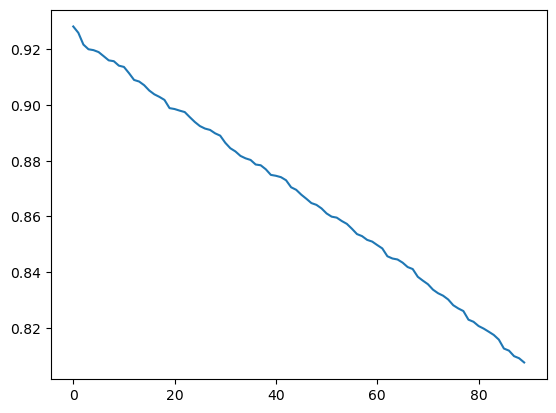

In [43]:
plt.plot(lqgspec[7, :])

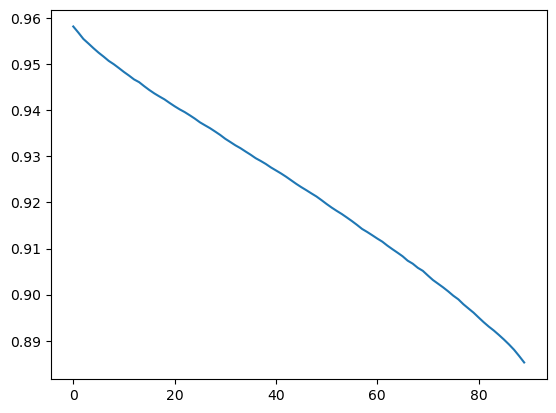

In [32]:
plt.plot(np.mean(lqgspec, axis=0))

In [ ]:
# This is a bit surprising. What does the spectrum look like at d = 30?

In [46]:
with open('/mnt/Secondary/data/postprocessed/indy_decoding_df2.dat', 'rb') as f:
    indy_df = pickle.load(f)
indy_df = pd.DataFrame(indy_df)

with open('/mnt/Secondary/data/postprocessed/loco_decoding_df.dat', 'rb') as f:
    loco_df = pickle.load(f)
loco_df = pd.DataFrame(loco_df)
loco_df = apply_df_filters(loco_df,
                        loader_args={'bin_width': 50, 'filter_fn': 'none', 'filter_kwargs': {}, 'boxcox': 0.5, 'spike_threshold': 100, 'region': 'M1'},
                        decoder_args={'trainlag': 4, 'testlag': 4, 'decoding_window': 5})
good_loco_files = ['loco_20170210_03.mat',
'loco_20170213_02.mat',
'loco_20170215_02.mat',
'loco_20170227_04.mat',
'loco_20170228_02.mat',
'loco_20170301_05.mat',
'loco_20170302_02.mat']

loco_df = apply_df_filters(loco_df, data_file=good_loco_files)        
sabes_df = pd.concat([loco_df, indy_df])

/home/akumar/anaconda3/envs/ncontrol/lib/python3.9/site-packages/sklearn/base.py:329: UserWarning: Trying to unpickle estimator LinearRegression from version 0.24.2 when using version 1.1.3. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/akumar/anaconda3/envs/ncontrol/lib/python3.9/site-packages/sklearn/base.py:329: UserWarning: Trying to unpickle estimator LinearRegression from version 0.24.2 when using version 1.1.3. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


In [50]:
spec = []
for fl in tqdm(fls):
    dat = load_sabes(fl)

    X = np.squeeze(dat['spike_rates'])

    lqgmodel = LQGCA(T=4)
    lqgmodel.estimate_data_statistics(X)

    df = apply_df_filters(sabes_df, data_file=fl.split('/')[-1], fold_idx=0, dim=30, dimreduc_method='LQGCA')
    assert(df.shape[0] == 1)

    V = torch.tensor(df.iloc[0]['coef']).float()

    s = get_LQG_spectrum(lqgmodel.cross_covs.float(), lqgmodel.cross_covs_rev.float(), V)
    print(np.trace(s))
    spec.append(s)


100%|██████████| 35/35 [04:20<00:00,  7.45s/it]


In [61]:
drspec = np.array([np.sort(s)[::-1][0:90] for s in spec])

In [71]:
[np.sum(s)/s.size for s in spec]

[0.9302895715994428,
 0.9498072798534106,
 0.9583637632172683,
 0.93353629912306,
 0.9566147644395773,
 0.9685624899323454,
 0.9215596896498951,
 0.9208069421294937,
 0.927000556193607,
 0.9229795483575352,
 0.9142729337098169,
 0.9274315800227172,
 0.9283711788428091,
 0.9398074902986225,
 0.9306289210464015,
 0.9327647242052802,
 0.9281823378342848,
 0.9279202547940341,
 0.9250709474548813,
 0.9272517491053868,
 0.9409841493118641,
 0.9190071165099625,
 0.9311123802548363,
 0.9401775828579015,
 0.9293467613958544,
 0.9319731118022532,
 0.9443334462691326,
 0.9419615372367527,
 0.9675638761451776,
 0.9733711722847465,
 0.9730437271238312,
 0.9746777378233139,
 0.9746793462426623,
 0.9702131652832031,
 0.9802337646484375]

In [ ]:
# This is suprisingly high dimensional

In [ ]:
# What about down to d=10?

### Scores

In [6]:
consolidate_dimreduc('/mnt/Secondary/data/sabes_dimreduc_highd', '/mnt/Secondary/data/postprocessed/sabes_highd_df.dat')
consolidate_dimreduc('/mnt/Secondary/data/peanut_dimreduc_highd', '/mnt/Secondary/data/postprocessed/peanut_highd_df.dat')
consolidate_dimreduc('/mnt/Secondary/data/cv_dimreduc_highd', '/mnt/Secondary/data/postprocessed/cv_highd_df.dat')

38
8
2


In [7]:
from sklearn.model_selection import KFold
from sklearn.decomposition import PCA

In [8]:
from dca_research.lqg import LQGComponentsAnalysis as LQGCA

In [15]:
with open('/mnt/Secondary/data/postprocessed/sabes_highd_df.dat', 'rb') as f:
    sabes_df = pickle.load(f)
sabes_df = pd.DataFrame(sabes_df)

In [9]:
# What is the fraction of the asymptotic LQR cost attained?
dimvals = np.unique(sabes_df['dim'].values)
data_files = np.unique(sabes_df['data_file'].values)

fcca_scores = np.zeros((dimvals.size, data_files.size, 2))
pca_scores = np.zeros((dimvals.size, data_files.size, 2))

for i, data_file in enumerate(data_files):
    dat = load_sabes('/mnt/Secondary/data/sabes/%s' % data_file)
    X = np.squeeze(dat['spike_rates'])
    pcamodel = PCA().fit(X)
    pca_ambient = np.sum(pcamodel.explained_variance_)
    for j, d in enumerate(dimvals):
        df = apply_df_filters(sabes_df, data_file=data_file, dimreduc_method='LQGCA', dim=d)
        assert(df.shape[0] == 1)
        lqgmodel = LQGCA(T=3)
        lqgscore = lqgmodel.score(X=X, coef=df.iloc[0]['coef'])
        fcca_scores[j, i, 0] = lqgscore            
        lqgscore = lqgmodel.score(X=X, coef=pcamodel.components_.T[:, 0:d])
        fcca_scores[j, i, 1] = lqgscore

        pca_scores[j, i, 0] = np.sum(pcamodel.explained_variance_ratio_[0:d])
        C = np.cov(X @ df.iloc[0]['coef'], rowvar=False)
        if d > 1:
            pca_scores[j, i, 1] = np.trace(np.cov(X @ df.iloc[0]['coef'], rowvar=False))/pca_ambient
        else:
            pca_scores[j, i, 1] = np.var(X @ df.iloc[0]['coef'])/pca_ambient
        

In [ ]:
# Normalize by the ambient scores
fcca_ambient = np.zeros((data_files.size))
for i, data_file in enumerate(data_files):
    dat = load_sabes('/mnt/Secondary/data/sabes/%s' % data_file)
    X = np.squeeze(dat['spike_rates'])
    lqgmodel = LQGCA(T=3)
    lqgscore = lqgmodel.score(X=X, coef=np.eye(X.shape[1]))
    fcca_ambient[i] = lqgscore

In [13]:
# Stash away
# with open('sabes_lqg_spectrum_tmp.pkl', 'wb') as f:
#     f.write(pickle.dumps(fcca_scores))
#     f.write(pickle.dumps(pca_scores))
#     f.write(pickle.dumps(fcca_ambient))
with open('sabes_lqg_spectrum_tmp.pkl', 'rb') as f:
    fcca_scores = pickle.load(f)
    pca_scores = pickle.load(f)
    fcca_ambient = pickle.load(f)

In [9]:
# S1
with open('/home/akumar/nse/neural_control/data/s1_dimreduc_highd_df.pkl', 'rb') as f:
    sabes_dfS1 = pickle.load(f)
sabes_dfS1 = pd.DataFrame(sabes_dfS1)

In [11]:
# What is the fraction of the asymptotic LQR cost attained?
dimvals = np.unique(sabes_dfS1['dim'].values)
data_files = np.unique(sabes_dfS1['data_file'].values)

fcca_scoress1 = np.zeros((dimvals.size, data_files.size, 2))
pca_scoress1 = np.zeros((dimvals.size, data_files.size, 2))

for i, data_file in enumerate(data_files):
    dat = load_sabes('/mnt/Secondary/data/sabes/%s' % data_file, region='S1')
    X = np.squeeze(dat['spike_rates'])
    pcamodel = PCA().fit(X)
    pca_ambient = np.sum(pcamodel.explained_variance_)
    for j, d in enumerate(dimvals):
        df = apply_df_filters(sabes_dfS1, data_file=data_file, dimreduc_method='LQGCA', dim=d)
        assert(df.shape[0] == 1)
        lqgmodel = LQGCA(T=3)
        lqgscore = lqgmodel.score(X=X, coef=df.iloc[0]['coef'])
        fcca_scoress1[j, i, 0] = lqgscore            
        lqgscore = lqgmodel.score(X=X, coef=pcamodel.components_.T[:, 0:d])
        fcca_scoress1[j, i, 1] = lqgscore

        pca_scoress1[j, i, 0] = np.sum(pcamodel.explained_variance_ratio_[0:d])
        C = np.cov(X @ df.iloc[0]['coef'], rowvar=False)
        if d > 1:
            pca_scoress1[j, i, 1] = np.trace(np.cov(X @ df.iloc[0]['coef'], rowvar=False))/pca_ambient
        else:
            pca_scoress1[j, i, 1] = np.var(X @ df.iloc[0]['coef'])/pca_ambient
        

96
96
96
96
96
96
96
96


In [12]:
# Normalize by the ambient scores
fcca_ambientS1 = np.zeros((data_files.size))
for i, data_file in enumerate(data_files):
    dat = load_sabes('/mnt/Secondary/data/sabes/%s' % data_file, region='S1')
    X = np.squeeze(dat['spike_rates'])
    lqgmodel = LQGCA(T=3)
    lqgscore = lqgmodel.score(X=X, coef=np.eye(X.shape[1]))
    fcca_ambientS1[i] = lqgscore

96
96
96
96
96
96
96
96


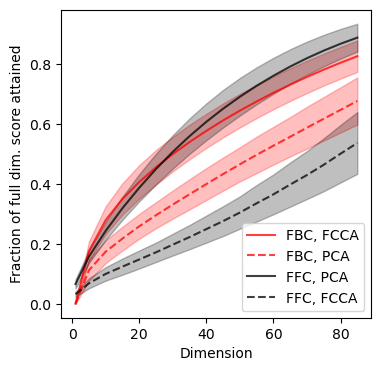

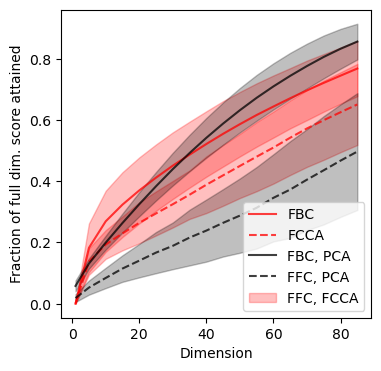

In [18]:
# Plot

# Plot percentage of asymptotic score attained
fcca_score_pcnt1 = (1 - np.divide(fcca_ambient - fcca_scores[..., 0], fcca_ambient - fcca_scores[0, :, 0]))
fcca_score_pcnt2 = (1 - np.divide(fcca_ambient - fcca_scores[..., 1], fcca_ambient - fcca_scores[0, :, 1]))

pca_score_pcnt1 = pca_scores[..., 0]
pca_score_pcnt2 = pca_scores[..., 1]

#fcca_score_normalized = np.divide(fcca_scores,fcca_ambient)
#fcca_score_normalizedp = np.divide(fcca_scoresp,fcca_ambientp)
#fcca_score_normalizedc = np.divide(fcca_scoresc,fcca_ambientc)

fig, ax = plt.subplots(1, 1, figsize=(4, 4))
dimvals = np.unique(sabes_df['dim'].values)
ax.plot(dimvals, np.mean(fcca_score_pcnt1, axis=-1), 'r', alpha=0.75)
ax.plot(dimvals, np.mean(fcca_score_pcnt2, axis=-1), 'r', linestyle='dashed', alpha=0.75)

ax.fill_between(dimvals, np.mean(fcca_score_pcnt1, axis=-1) - np.std(fcca_score_pcnt1, axis=-1), 
                np.mean(fcca_score_pcnt1, axis=-1) + np.std(fcca_score_pcnt1, axis=-1), color='r', alpha=0.25)
ax.fill_between(dimvals, np.mean(fcca_score_pcnt2, axis=-1) - np.std(fcca_score_pcnt2, axis=-1), 
                np.mean(fcca_score_pcnt2, axis=-1) + np.std(fcca_score_pcnt2, axis=-1), color='r', alpha=0.25)


ax.plot(dimvals, np.mean(pca_score_pcnt1, axis=-1), 'k', alpha=0.75)
ax.plot(dimvals, np.mean(pca_score_pcnt2, axis=-1), 'k', linestyle='dashed', alpha=0.75)

ax.fill_between(dimvals, np.mean(pca_score_pcnt1, axis=-1) - np.std(pca_score_pcnt1, axis=-1), 
                np.mean(pca_score_pcnt1, axis=-1) + np.std(pca_score_pcnt1, axis=-1), color='k', alpha=0.25)
ax.fill_between(dimvals, np.mean(pca_score_pcnt2, axis=-1) - np.std(pca_score_pcnt2, axis=-1), 
                np.mean(pca_score_pcnt2, axis=-1) + np.std(pca_score_pcnt2, axis=-1), color='k', alpha=0.25)

ax.legend(['FBC, FCCA', 'FBC, PCA', 'FFC, PCA', 'FFC, FCCA'], loc='lower right')
ax.set_xlabel('Dimension')
ax.set_ylabel('Fraction of full dim. score attained')
fig.savefig('/home/akumar/nse/neural_control/figs/loco_indy_merge/sabes_scores.pdf', bbox_inches='tight', pad_inches=0)
########################################################################################################################
########################################################################################################################

fcca_score_pcnt1 = (1 - np.divide(fcca_ambientS1 - fcca_scoress1[..., 0], fcca_ambientS1 - fcca_scoress1[0, :, 0]))
fcca_score_pcnt2 = (1 - np.divide(fcca_ambientS1 - fcca_scoress1[..., 1], fcca_ambientS1 - fcca_scoress1[0, :, 1]))

pca_score_pcnt1 = pca_scoress1[..., 0]
pca_score_pcnt2 = pca_scoress1[..., 1]

#fcca_score_normalized = np.divide(fcca_scores,fcca_ambient)
#fcca_score_normalizedp = np.divide(fcca_scoresp,fcca_ambientp)
#fcca_score_normalizedc = np.divide(fcca_scoresc,fcca_ambientc)

fig, ax = plt.subplots(1, 1, figsize=(4, 4))
dimvals = np.unique(sabes_dfS1['dim'].values)
ax.plot(dimvals, np.mean(fcca_score_pcnt1, axis=-1), 'r', alpha=0.75)
ax.plot(dimvals, np.mean(fcca_score_pcnt2, axis=-1), 'r', linestyle='dashed', alpha=0.75)

ax.fill_between(dimvals, np.mean(fcca_score_pcnt1, axis=-1) - np.std(fcca_score_pcnt1, axis=-1), 
                np.mean(fcca_score_pcnt1, axis=-1) + np.std(fcca_score_pcnt1, axis=-1), color='r', alpha=0.25)
ax.fill_between(dimvals, np.mean(fcca_score_pcnt2, axis=-1) - np.std(fcca_score_pcnt2, axis=-1), 
                np.mean(fcca_score_pcnt2, axis=-1) + np.std(fcca_score_pcnt2, axis=-1), color='r', alpha=0.25)


ax.plot(dimvals, np.mean(pca_score_pcnt1, axis=-1), 'k', alpha=0.75)
ax.plot(dimvals, np.mean(pca_score_pcnt2, axis=-1), 'k', linestyle='dashed', alpha=0.75)

ax.fill_between(dimvals, np.mean(pca_score_pcnt1, axis=-1) - np.std(pca_score_pcnt1, axis=-1), 
                np.mean(pca_score_pcnt1, axis=-1) + np.std(pca_score_pcnt1, axis=-1), color='k', alpha=0.25)
ax.fill_between(dimvals, np.mean(pca_score_pcnt2, axis=-1) - np.std(pca_score_pcnt2, axis=-1), 
                np.mean(pca_score_pcnt2, axis=-1) + np.std(pca_score_pcnt2, axis=-1), color='k', alpha=0.25)

ax.legend(['FBC', 'FCCA', 'FBC, PCA', 'FFC, PCA', 'FFC, FCCA'], loc='lower right')
ax.set_xlabel('Dimension')
ax.set_ylabel('Fraction of full dim. score attained')
fig.savefig('/home/akumar/nse/neural_control/figs/loco_indy_merge/sabesS1_scores.pdf', bbox_inches='tight', pad_inches=0)

In [63]:
# Peanut
with open('/mnt/Secondary/data/postprocessed/peanut_highd_df.dat', 'rb') as f:
    peanut_df = pickle.load(f)
peanut_df = pd.DataFrame(peanut_df)

In [64]:
# What is the fraction of the asymptotic LQR cost attained?
dimvals = np.unique(peanut_df['dim'].values)
epochs = np.arange(2, 18, 2)

fcca_scoresp = np.zeros((dimvals.size, epochs.size, 2))
pca_scoresp = np.zeros((dimvals.size, epochs.size, 2))

data_path = '/mnt/Secondary/data/peanut'
data_file = '%s/data_dict_peanut_day14.obj' % data_path

for i, epoch in enumerate(epochs):

    loader_args = {'bin_width': 50,
    'epoch': epoch,
    'filter_fn': 'none',
    'filter_kwargs': {},
    'boxcox': 0.5,
    'spike_threshold': 200,
    'speed_threshold': 4}

    dat = load_peanut(data_file, **loader_args)
    X = np.squeeze(dat['spike_rates'])
    pcamodel = PCA().fit(X)
    pca_ambient = np.sum(pcamodel.explained_variance_)
    for j, d in enumerate(dimvals):
        df = apply_df_filters(peanut_df, loader_args=loader_args, dimreduc_method='LQGCA', dim=d)
        assert(df.shape[0] == 1)
        lqgmodel = LQGCA(T=3)
        lqgscore = lqgmodel.score(X=X, coef=df.iloc[0]['coef'])
        fcca_scoresp[j, i, 0] = lqgscore

        lqgscore = lqgmodel.score(X=X, coef=pcamodel.components_.T[:, 0:d])
        fcca_scoresp[j, i, 1] = lqgscore

        pca_scoresp[j, i, 0] = np.sum(pcamodel.explained_variance_ratio_[0:d])
        if d > 1:
            pca_scoresp[j, i, 1] = np.trace(np.cov(X @ df.iloc[0]['coef'], rowvar=False))/pca_ambient
        else:
            pca_scoresp[j, i, 1] = np.var(X @ df.iloc[0]['coef'])/pca_ambient


In [66]:
# Normalize by the ambient scores
data_path = '/mnt/Secondary/data/peanut'
data_file = '%s/data_dict_peanut_day14.obj' % data_path

fcca_ambientp = np.zeros((epochs.size))
for i, epoch in enumerate(epochs):
    loader_args = {'bin_width': 50,
    'epoch': epoch,
    'filter_fn': 'none',
    'filter_kwargs': {},
    'boxcox': 0.5,
    'spike_threshold': 200,
    'speed_threshold': 4}

    dat = load_peanut(data_file, **loader_args)
    X = np.squeeze(dat['spike_rates'])
    lqgmodel = LQGCA(T=3)
    lqgscore = lqgmodel.score(X=X, coef=np.eye(X.shape[1]))
    fcca_ambientp[i] = lqgscore

NameError: name 'fcca_ambientp' is not defined

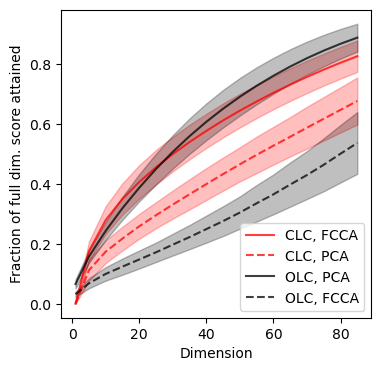

In [16]:
# Plot

# Plot percentage of asymptotic score attained
fcca_score_pcnt1 = (1 - np.divide(fcca_ambient - fcca_scores[..., 0], fcca_ambient - fcca_scores[0, :, 0]))
fcca_score_pcnt2 = (1 - np.divide(fcca_ambient - fcca_scores[..., 1], fcca_ambient - fcca_scores[0, :, 1]))

pca_score_pcnt1 = pca_scores[..., 0]
pca_score_pcnt2 = pca_scores[..., 1]

#fcca_score_normalized = np.divide(fcca_scores,fcca_ambient)
#fcca_score_normalizedp = np.divide(fcca_scoresp,fcca_ambientp)
#fcca_score_normalizedc = np.divide(fcca_scoresc,fcca_ambientc)

fig, ax = plt.subplots(1, 1, figsize=(4, 4))
dimvals = np.unique(sabes_df['dim'].values)
ax.plot(dimvals, np.mean(fcca_score_pcnt1, axis=-1), 'r', alpha=0.75)
ax.plot(dimvals, np.mean(fcca_score_pcnt2, axis=-1), 'r', linestyle='dashed', alpha=0.75)

ax.fill_between(dimvals, np.mean(fcca_score_pcnt1, axis=-1) - np.std(fcca_score_pcnt1, axis=-1), 
                np.mean(fcca_score_pcnt1, axis=-1) + np.std(fcca_score_pcnt1, axis=-1), color='r', alpha=0.25)
ax.fill_between(dimvals, np.mean(fcca_score_pcnt2, axis=-1) - np.std(fcca_score_pcnt2, axis=-1), 
                np.mean(fcca_score_pcnt2, axis=-1) + np.std(fcca_score_pcnt2, axis=-1), color='r', alpha=0.25)


ax.plot(dimvals, np.mean(pca_score_pcnt1, axis=-1), 'k', alpha=0.75)
ax.plot(dimvals, np.mean(pca_score_pcnt2, axis=-1), 'k', linestyle='dashed', alpha=0.75)

ax.fill_between(dimvals, np.mean(pca_score_pcnt1, axis=-1) - np.std(pca_score_pcnt1, axis=-1), 
                np.mean(pca_score_pcnt1, axis=-1) + np.std(pca_score_pcnt1, axis=-1), color='k', alpha=0.25)
ax.fill_between(dimvals, np.mean(pca_score_pcnt2, axis=-1) - np.std(pca_score_pcnt2, axis=-1), 
                np.mean(pca_score_pcnt2, axis=-1) + np.std(pca_score_pcnt2, axis=-1), color='k', alpha=0.25)

ax.legend(['CLC, FCCA', 'CLC, PCA', 'OLC, PCA', 'OLC, FCCA'], loc='lower right')
ax.set_xlabel('Dimension')
ax.set_ylabel('Fraction of full dim. score attained')
fig.savefig('/home/akumar/nse/neural_control/figs/loco_indy_merge/sabes_scores.pdf', bbox_inches='tight', pad_inches=0)
########################################################################################################################
########################################################################################################################

fcca_score_pcnt1 = (1 - np.divide(fcca_ambientp - fcca_scoresp[..., 0], fcca_ambientp - fcca_scoresp[0, :, 0]))
fcca_score_pcnt2 = (1 - np.divide(fcca_ambientp - fcca_scoresp[..., 1], fcca_ambientp - fcca_scoresp[0, :, 1]))

pca_score_pcnt1 = pca_scoresp[..., 0]
pca_score_pcnt2 = pca_scoresp[..., 1]

#fcca_score_normalized = np.divide(fcca_scores,fcca_ambient)
#fcca_score_normalizedp = np.divide(fcca_scoresp,fcca_ambientp)
#fcca_score_normalizedc = np.divide(fcca_scoresc,fcca_ambientc)

fig, ax = plt.subplots(1, 1, figsize=(4, 4))
dimvals = np.unique(peanut_df['dim'].values)
ax.plot(dimvals, np.mean(fcca_score_pcnt1, axis=-1), 'r', alpha=0.75)
ax.plot(dimvals, np.mean(fcca_score_pcnt2, axis=-1), 'r', linestyle='dashed', alpha=0.75)

ax.fill_between(dimvals, np.mean(fcca_score_pcnt1, axis=-1) - np.std(fcca_score_pcnt1, axis=-1), 
                np.mean(fcca_score_pcnt1, axis=-1) + np.std(fcca_score_pcnt1, axis=-1), color='r', alpha=0.25)
ax.fill_between(dimvals, np.mean(fcca_score_pcnt2, axis=-1) - np.std(fcca_score_pcnt2, axis=-1), 
                np.mean(fcca_score_pcnt2, axis=-1) + np.std(fcca_score_pcnt2, axis=-1), color='r', alpha=0.25)


ax.plot(dimvals, np.mean(pca_score_pcnt1, axis=-1), 'k', alpha=0.75)
ax.plot(dimvals, np.mean(pca_score_pcnt2, axis=-1), 'k', linestyle='dashed', alpha=0.75)

ax.fill_between(dimvals, np.mean(pca_score_pcnt1, axis=-1) - np.std(pca_score_pcnt1, axis=-1), 
                np.mean(pca_score_pcnt1, axis=-1) + np.std(pca_score_pcnt1, axis=-1), color='k', alpha=0.25)
ax.fill_between(dimvals, np.mean(pca_score_pcnt2, axis=-1) - np.std(pca_score_pcnt2, axis=-1), 
                np.mean(pca_score_pcnt2, axis=-1) + np.std(pca_score_pcnt2, axis=-1), color='k', alpha=0.25)

ax.legend(['CLC, FCCA', 'CLC, PCA', 'OLC, PCA', 'OLC, FCCA'], loc='lower right')
ax.set_xlabel('Dimension')
ax.set_ylabel('Fraction of full dim. score attained')
fig.savefig('/home/akumar/nse/neural_control/figs/loco_indy_merge/peanut_scores.pdf', bbox_inches='tight', pad_inches=0)

### Sequential subspace angles

In [ ]:
# Look at pairwise and sequential subspace angles in the original dataframes

In [6]:
dframe_indy = '/mnt/Secondary/data/postprocessed/indy_decoding_df2.dat'
dframe_loco = '/mnt/Secondary/data/postprocessed/loco_decoding_df.dat'

print('Using dframes %s, %s' % (dframe_indy, dframe_loco))

with open(dframe_indy, 'rb') as f:
    rl = pickle.load(f)
indy_df = pd.DataFrame(rl)

with open(dframe_loco, 'rb') as f:
    loco_df = pickle.load(f)
loco_df = pd.DataFrame(loco_df)
loco_df = apply_df_filters(loco_df,
                        loader_args={'bin_width': 50, 'filter_fn': 'none', 'filter_kwargs': {}, 'boxcox': 0.5, 'spike_threshold': 100, 'region': 'M1'},
                        decoder_args={'trainlag': 4, 'testlag': 4, 'decoding_window': 5})
good_loco_files = ['loco_20170210_03.mat',
'loco_20170213_02.mat',
'loco_20170215_02.mat',
'loco_20170227_04.mat',
'loco_20170228_02.mat',
'loco_20170301_05.mat',
'loco_20170302_02.mat']

loco_df = apply_df_filters(loco_df, data_file=good_loco_files)     

Using dframes /mnt/Secondary/data/postprocessed/indy_decoding_df2.dat, /mnt/Secondary/data/postprocessed/loco_decoding_df.dat


/home/akumar/anaconda3/envs/ncontrol/lib/python3.9/site-packages/sklearn/base.py:329: UserWarning: Trying to unpickle estimator LinearRegression from version 0.24.2 when using version 1.1.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/akumar/anaconda3/envs/ncontrol/lib/python3.9/site-packages/sklearn/base.py:329: UserWarning: Trying to unpickle estimator LinearRegression from version 0.24.2 when using version 1.1.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


In [7]:
sabes_df = pd.concat([indy_df, loco_df])

In [9]:
sabes_df.keys()

Index(['dim', 'fold_idx', 'train_idxs', 'test_idxs', 'dimreduc_method',
       'dimreduc_args', 'coef', 'score', 'bin_width', 'filter_fn',
       'filter_kwargs', 'boxcox', 'spike_threshold', 'dim_vals', 'n_folds',
       'data_file', 'decoder', 'decoder_args', 'decoder_obj', 'r2', 'loader',
       'loader_args', 'task_args', 'data_path', 'results_file'],
      dtype='object')

In [8]:
dimvals = np.unique(sabes_df['dim'].values)[:-1]
data_files = np.unique(sabes_df['data_file'].values)
ssa_df = []

ssa1_median = np.zeros((len(data_files), len(dimvals), 5))
ssa1_min = np.zeros((len(data_files), len(dimvals), 5))
ssa1_max = np.zeros((len(data_files), len(dimvals), 5))

ssa2_median = np.zeros((len(data_files), len(dimvals), 5))
ssa2_min = np.zeros((len(data_files), len(dimvals), 5))
ssa2_max = np.zeros((len(data_files), len(dimvals), 5))

# Reference of what PCA looks like
ssa3_mean = np.zeros((len(data_files), len(dimvals), 5))
ssa3_min = np.zeros((len(data_files), len(dimvals), 5))
ssa3_max = np.zeros((len(data_files), len(dimvals), 5))

for i, data_file in enumerate(data_files):
    for j, dim in enumerate(dimvals):
        for f in range(5):
            dfd1_fc = apply_df_filters(sabes_df, dim=dim, data_file=data_file, fold_idx=f, dimreduc_method='LQGCA')
            dfd1_pc = apply_df_filters(sabes_df, dim=dim, data_file=data_file, fold_idx=f, dimreduc_method='PCA')

            assert(dfd1_fc.shape[0] == 1)
            assert(dfd1_pc.shape[0] == 1)

            dfd2 = apply_df_filters(sabes_df, dim=dim + 1, data_file=data_file, fold_idx=f, dimreduc_method='LQGCA')
            assert(dfd2.shape[0] == 1)

            ssa1 = scipy.linalg.subspace_angles(dfd1_fc.iloc[0]['coef'], dfd1_pc.iloc[0]['coef'][:, 0:dim])
            ssa2 = scipy.linalg.subspace_angles(dfd1_fc.iloc[0]['coef'], dfd2.iloc[0]['coef'])

            dfd2 = apply_df_filters(sabes_df, dim=dim + 1, data_file=data_file, fold_idx=f, dimreduc_method='PCA')
            assert(dfd2.shape[0] == 1)
            ssa3 = scipy.linalg.subspace_angles(dfd1_pc.iloc[0]['coef'][:, 0:dim], dfd2.iloc[0]['coef'][:, 0:dim])

            r = {}
            r['data_file'] = data_file
            r['dim'] = dim
            r['fold'] = f
            r['ssa1'] = ssa1
            r['ssa2'] = ssa2

            ssa1_median[i, j, f] = np.median(ssa1)
            ssa1_min[i, j, f] = np.min(ssa1)
            ssa1_max[i, j, f] = np.max(ssa1)

            ssa2_median[i, j, f] = np.median(ssa2[0:dim])
            ssa2_min[i, j, f] = np.min(ssa2)
            ssa2_max[i, j, f] = np.max(ssa2)

            ssa3_mean[i, j, f] = np.mean(ssa3[0:dim])
            ssa3_min[i, j, f] = np.min(ssa3)
            ssa3_max[i, j, f] = np.max(ssa3)


In [11]:
np.pi/2

1.5707963267948966

In [12]:
dimvals[8]

9

In [14]:
1.3

1.1780972450961724

In [13]:
np.mean(np.mean(ssa1_median, axis=0), axis=-1)

array([0.86821212, 1.01495794, 1.0921105 , 1.11194017, 1.12543096,
       1.14200775, 1.15672756, 1.18742558, 1.21510734, 1.22923057,
       1.24837436, 1.25972949, 1.27434503, 1.28104739, 1.28585703,
       1.29264219, 1.3001253 , 1.30629562, 1.3117172 , 1.31196328,
       1.31232278, 1.3142968 , 1.31561672, 1.31636439, 1.31563786,
       1.31507681, 1.31402113, 1.31354506, 1.31190228])

In [10]:
np.mean(np.mean(ssa1_max, axis=0), axis=-1)

array([0.86821212, 1.19356157, 1.357566  , 1.41585106, 1.47148387,
       1.49735531, 1.52199236, 1.53370783, 1.54405865, 1.54841782,
       1.5514336 , 1.55510587, 1.55881894, 1.55818667, 1.55974893,
       1.56062618, 1.56135585, 1.56225139, 1.56293956, 1.56327252,
       1.56349531, 1.56416258, 1.56401225, 1.5645719 , 1.56496351,
       1.56548302, 1.56561135, 1.56524943, 1.56527189])

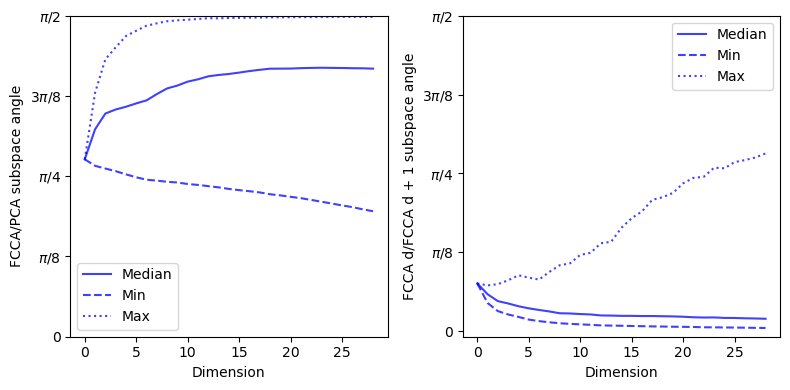

In [12]:
fig, ax = plt.subplots(1, 2, figsize=(8, 4))
ax[0].plot(np.mean(np.mean(ssa1_median, axis=0), axis=-1), color='b', alpha=0.75, linestyle='-')
ax[0].plot(np.mean(np.mean(ssa1_min, axis=0), axis=-1), color='b', alpha=0.75, linestyle='--')
ax[0].plot(np.mean(np.mean(ssa1_max, axis=0), axis=-1), color='b', alpha=0.75, linestyle=':')

ax[1].plot(np.mean(np.mean(ssa2_median, axis=0), axis=-1), color='b', alpha=0.75, linestyle='-')
ax[1].plot(np.mean(np.mean(ssa2_min, axis=0), axis=-1), color='b', alpha=0.75, linestyle='--')
ax[1].plot(np.mean(np.mean(ssa2_max, axis=0), axis=-1), color='b', alpha=0.75, linestyle=':')

ax[0].set_ylim([0, np.pi/2])
ax[0].set_yticks([0, np.pi/8, np.pi/4, 3 * np.pi/8, np.pi/2])
ax[0].set_yticklabels(['0', r'$\pi/8$', r'$\pi/4$', r'$3\pi/8$', r'$\pi/2$'])

ax[0].set_ylabel('FCCA/PCA subspace angle')
ax[0].set_xlabel('Dimension')
ax[0].legend(['Median', 'Min', 'Max'])
    
ax[1].set_ylabel('FCCA d/FCCA d + 1 subspace angle')
ax[1].set_xlabel('Dimension')
ax[1].legend(['Median', 'Min', 'Max'])
ax[1].set_yticks([0, np.pi/8, np.pi/4, 3 * np.pi/8, np.pi/2])
ax[1].set_yticklabels(['0', r'$\pi/8$', r'$\pi/4$', r'$3\pi/8$', r'$\pi/2$'])

# ax[1].plot(np.mean(np.mean(ssa3_mean, axis=0), axis=-1))
# ax[1].plot(np.mean(np.mean(ssa3_min, axis=0), axis=-1))
# ax[1].plot(np.mean(np.mean(ssa3_max, axis=0), axis=-1))
fig.tight_layout()
fig.savefig('/home/akumar/nse/neural_control/figs/loco_indy_merge/ssa_vdim.pdf', bbox_inches='tight', pad_inches=0)

### Sequential Subspace Angles in S1

In [15]:
with open('/mnt/Secondary/data/postprocessed/loco_lag1_decodingdf.dat', 'rb') as f:
    result_list = pickle.load(f)
with open('/mnt/Secondary/data/postprocessed/indy_S1_decodingdf.dat', 'rb') as f:
    rl2 = pickle.load(f)

loco_df = pd.DataFrame(result_list)
# filter by good files
good_loco_files = ['loco_20170210_03.mat',
'loco_20170213_02.mat',
'loco_20170215_02.mat',
'loco_20170227_04.mat',
'loco_20170228_02.mat',
'loco_20170301_05.mat',
'loco_20170302_02.mat']

loco_df = apply_df_filters(loco_df, data_file=good_loco_files, 
                            loader_args={'bin_width': 50, 'filter_fn': 'none', 'filter_kwargs': {}, 
                            'boxcox': 0.5, 'spike_threshold': 100, 'region': 'S1'})

indy_df = pd.DataFrame(rl2)        

sabes_df = pd.concat([loco_df, indy_df])

In [16]:
dimvals = np.unique(sabes_df['dim'].values)[:-1]
data_files = np.unique(sabes_df['data_file'].values)
ssa_df = []

ssa1_median = np.zeros((len(data_files), len(dimvals), 5))
ssa1_min = np.zeros((len(data_files), len(dimvals), 5))
ssa1_max = np.zeros((len(data_files), len(dimvals), 5))

ssa2_median = np.zeros((len(data_files), len(dimvals), 5))
ssa2_min = np.zeros((len(data_files), len(dimvals), 5))
ssa2_max = np.zeros((len(data_files), len(dimvals), 5))

# Reference of what PCA looks like
ssa3_mean = np.zeros((len(data_files), len(dimvals), 5))
ssa3_min = np.zeros((len(data_files), len(dimvals), 5))
ssa3_max = np.zeros((len(data_files), len(dimvals), 5))

for i, data_file in enumerate(data_files):
    for j, dim in enumerate(dimvals):
        for f in range(5):
            dfd1_fc = apply_df_filters(sabes_df, dim=dim, data_file=data_file, fold_idx=f, dimreduc_method='LQGCA')
            dfd1_pc = apply_df_filters(sabes_df, dim=dim, data_file=data_file, fold_idx=f, dimreduc_method='PCA')

            assert(dfd1_fc.shape[0] == 1)
            assert(dfd1_pc.shape[0] == 1)

            dfd2 = apply_df_filters(sabes_df, dim=dim + 1, data_file=data_file, fold_idx=f, dimreduc_method='LQGCA')
            assert(dfd2.shape[0] == 1)

            ssa1 = scipy.linalg.subspace_angles(dfd1_fc.iloc[0]['coef'], dfd1_pc.iloc[0]['coef'][:, 0:dim])
            ssa2 = scipy.linalg.subspace_angles(dfd1_fc.iloc[0]['coef'], dfd2.iloc[0]['coef'])

            dfd2 = apply_df_filters(sabes_df, dim=dim + 1, data_file=data_file, fold_idx=f, dimreduc_method='PCA')
            assert(dfd2.shape[0] == 1)
            ssa3 = scipy.linalg.subspace_angles(dfd1_pc.iloc[0]['coef'][:, 0:dim], dfd2.iloc[0]['coef'][:, 0:dim])

            r = {}
            r['data_file'] = data_file
            r['dim'] = dim
            r['fold'] = f
            r['ssa1'] = ssa1
            r['ssa2'] = ssa2

            ssa1_median[i, j, f] = np.median(ssa1)
            ssa1_min[i, j, f] = np.min(ssa1)
            ssa1_max[i, j, f] = np.max(ssa1)

            ssa2_median[i, j, f] = np.median(ssa2[0:dim])
            ssa2_min[i, j, f] = np.min(ssa2)
            ssa2_max[i, j, f] = np.max(ssa2)

            ssa3_mean[i, j, f] = np.mean(ssa3[0:dim])
            ssa3_min[i, j, f] = np.min(ssa3)
            ssa3_max[i, j, f] = np.max(ssa3)


In [17]:
np.mean(np.mean(ssa1_median, axis=0), axis=-1)

array([1.31605426, 1.1799327 , 1.30819515, 1.20602375, 1.20118819,
       1.17655558, 1.16927173, 1.21102184, 1.24959354, 1.24744667,
       1.25226211, 1.24879509, 1.26015305, 1.26372562, 1.27655573,
       1.2790523 , 1.28453635, 1.28961563, 1.29696969, 1.28760113,
       1.29554567, 1.29663805, 1.29032904, 1.29934944, 1.29412059,
       1.29764488, 1.29613893, 1.29098586, 1.28884502])

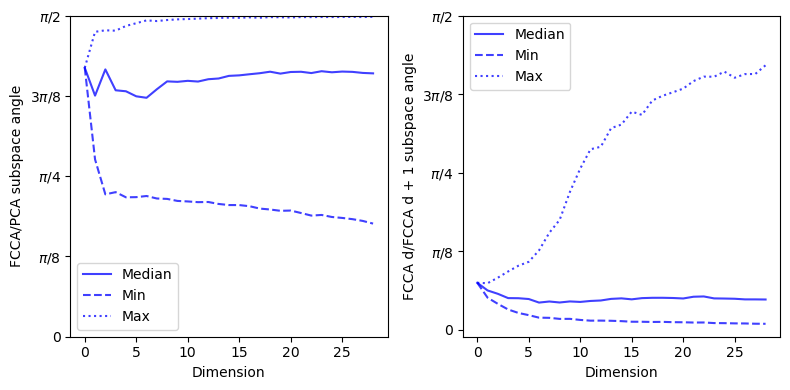

In [8]:
fig, ax = plt.subplots(1, 2, figsize=(8, 4))
ax[0].plot(np.mean(np.mean(ssa1_median, axis=0), axis=-1), color='b', alpha=0.75, linestyle='-')
ax[0].plot(np.mean(np.mean(ssa1_min, axis=0), axis=-1), color='b', alpha=0.75, linestyle='--')
ax[0].plot(np.mean(np.mean(ssa1_max, axis=0), axis=-1), color='b', alpha=0.75, linestyle=':')

ax[1].plot(np.mean(np.mean(ssa2_median, axis=0), axis=-1), color='b', alpha=0.75, linestyle='-')
ax[1].plot(np.mean(np.mean(ssa2_min, axis=0), axis=-1), color='b', alpha=0.75, linestyle='--')
ax[1].plot(np.mean(np.mean(ssa2_max, axis=0), axis=-1), color='b', alpha=0.75, linestyle=':')

ax[0].set_ylim([0, np.pi/2])
ax[0].set_yticks([0, np.pi/8, np.pi/4, 3 * np.pi/8, np.pi/2])
ax[0].set_yticklabels(['0', r'$\pi/8$', r'$\pi/4$', r'$3\pi/8$', r'$\pi/2$'])

ax[0].set_ylabel('FCCA/PCA subspace angle')
ax[0].set_xlabel('Dimension')
ax[0].legend(['Median', 'Min', 'Max'])

ax[1].set_ylabel('FCCA d/FCCA d + 1 subspace angle')
ax[1].set_xlabel('Dimension')
ax[1].legend(['Median', 'Min', 'Max'])
ax[1].set_yticks([0, np.pi/8, np.pi/4, 3 * np.pi/8, np.pi/2])
ax[1].set_yticklabels(['0', r'$\pi/8$', r'$\pi/4$', r'$3\pi/8$', r'$\pi/2$'])

# ax[1].plot(np.mean(np.mean(ssa3_mean, axis=0), axis=-1))
# ax[1].plot(np.mean(np.mean(ssa3_min, axis=0), axis=-1))
# ax[1].plot(np.mean(np.mean(ssa3_max, axis=0), axis=-1))
fig.tight_layout()
fig.savefig('/home/akumar/nse/neural_control/figs/loco_indy_merge/ssa_vdimS1.pdf', bbox_inches='tight', pad_inches=0)